<a href="https://colab.research.google.com/github/Soccolo/GPVAE/blob/main/Prior_VAE_python38_28x28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing libraries and Python

In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 293 kB 6.8 MB/s 


In [ ]:
!pip install arviz==0.13.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 97.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Uninstalling arviz-0.15.1:
      Successfully uninstalled arviz-0.15.1


In [ ]:
!pip install pyreadr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 kB 17.1 MB/s eta 0:00:00


In [ ]:
!pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
# general libraries
import time
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#import arviz as az
#import pyreadr

# JAX
import jax.numpy as jnp
from jax import random, lax, jit, ops
from jax.example_libraries import stax

from functools import partial

# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive
from numpyro.diagnostics import hpdi

import pickle

#Sampling Gaussian Process

In [ ]:
def dist_euclid(x, z):
    x = jnp.array(x)
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-6):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k


def GP(gp_kernel, x, jitter=1e-5, var=None, length=None, y=None, noise=False):

    if length==None:
        length = numpyro.sample("kernel_length", dist.InverseGamma(4,1))

    if var==None:
        var = numpyro.sample("kernel_var", dist.LogNormal(0.,0.1))

    k = gp_kernel(x, x, var, length, jitter)

    if noise==False:
        numpyro.sample("y",  dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k), obs=y)
    else:
        sigma = numpyro.sample("noise", dist.HalfNormal(0.1))
        f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))
        numpyro.sample("y", dist.Normal(f, sigma), obs=y)

In [ ]:
args = {"n": 28,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(2)
}

# create grid and draw priors
x = [jnp.array((i, j)) for i in jnp.arange(0, 1, 1/args["n"]) for j in jnp.arange(0, 1, 1/args["n"])]
x = jnp.asarray(x, dtype = np.float32)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
gp_predictive = Predictive(GP, num_samples=5)
gp_draws = gp_predictive(rng_key_predict, x=x, gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

In [ ]:
z = gp_draws[1].reshape((args['n'], args['n']))

In [ ]:
def heatmap2d(arr):
    plt.imshow(arr, cmap='viridis')
    plt.colorbar()
    plt.show()

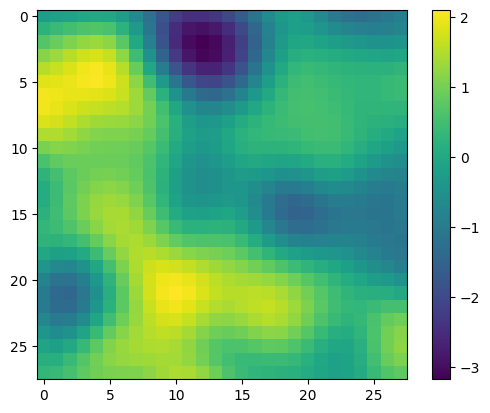

In [ ]:
heatmap2d(z)

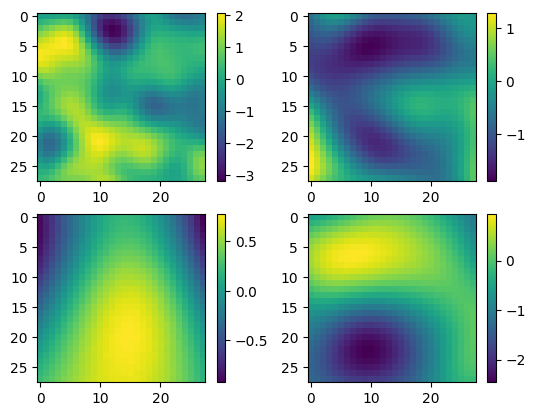

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(gp_draws[1].reshape((args['n'], args['n'])))
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(gp_draws[2].reshape((args['n'], args['n'])))
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(gp_draws[3].reshape((args['n'], args['n'])))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(gp_draws[4].reshape((args['n'], args['n'])))
plt.colorbar()

#Coding the VAE

In [ ]:
args = {"num_epochs": 160,
        "learning_rate": 1.0e-3,
        "batch_size": 100,
        "hidden_dim1": 35,
        "hidden_dim2": 30,
        "z_dim": 30,
         "x": x,
        "n": 28,
        "gp_kernel": exp_sq_kernel,
        "rng_key": random.PRNGKey(1),
        "num_warmup": 1000,
        "num_samples": 1000,
        "num_chains": 4,
        "thinning": 10
        }

def vae_encoder(hidden_dim1, hidden_dim2, z_dim):
    return stax.serial(
        stax.Flatten,
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.FanOut(2),
        stax.parallel(
            stax.Dense(z_dim, W_init=stax.randn()),  # mean
            stax.serial(stax.Dense(z_dim, W_init=stax.randn()), stax.Exp),  # std -- i.e. diagonal covariance
        ),
    )


def vae_decoder(hidden_dim1, hidden_dim2, out_dim):
    return stax.serial(
        stax.Dense(hidden_dim1, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(hidden_dim2, W_init=stax.randn()),
        stax.Relu,
        stax.Dense(out_dim, W_init=stax.randn())
    )

def vae_model(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    decode = numpyro.module("decoder", vae_decoder(hidden_dim1, hidden_dim2, out_dim), input_shape=(z_dim,))
    z = numpyro.sample("z", dist.Normal(jnp.zeros((batch_dim, z_dim)), jnp.ones((batch_dim, z_dim))))
    gen_loc = decode(z)
    return numpyro.sample("obs", dist.Normal(gen_loc, .1), obs=batch)


def vae_guide(batch, hidden_dim1, hidden_dim2, z_dim):
    batch = jnp.reshape(batch, (batch.shape[0], -1))
    batch_dim, out_dim = jnp.shape(batch)
    encode = numpyro.module("encoder", vae_encoder(hidden_dim1, hidden_dim2, z_dim), input_shape = (batch_dim, out_dim))
    z_loc, z_std = encode(batch)
    z = numpyro.sample("z", dist.Normal(z_loc, z_std))
    return z


@jit
def epoch_train(rng_key, svi_state, num_train):
    def body_fn(i, val):
        rng_key_i = random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        loss_sum, svi_state = val  # val -- svi_state
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        svi_state, loss = svi.update(svi_state, batch['y'])
        loss_sum += loss / args['batch_size']
        return loss_sum, svi_state

    return lax.fori_loop(0, num_train, body_fn, (0.0, svi_state))


@jit
def eval_test(rng_key, svi_state, num_test):
    def body_fn(i, loss_sum):
        rng_key_i = random.fold_in(rng_key, i)
        rng_key_i, rng_key_ls, rng_key_var, rng_key_noise = random.split(rng_key_i, 4)
        batch = gp_predictive(rng_key_i, gp_kernel=args["gp_kernel"], x=args["x"], jitter=1e-4)
        loss = svi.evaluate(svi_state, batch['y']) / args['batch_size']
        loss_sum += loss
        return loss_sum

    loss = lax.fori_loop(0, num_test, body_fn, 0.0)
    loss = loss / num_test

    return loss


In [ ]:
adam = numpyro.optim.Adam(step_size=args["learning_rate"])
svi = SVI(vae_model, vae_guide, adam, Trace_ELBO(),
          hidden_dim1=args["hidden_dim1"],
          hidden_dim2=args["hidden_dim2"],
          z_dim=args["z_dim"])

rng_key, rng_key_samp, rng_key_init = random.split(args["rng_key"], 3)
init_batch = gp_predictive(rng_key_predict, x=args["x"], gp_kernel=args["gp_kernel"])['y']
svi_state = svi.init(rng_key_init, init_batch)

test_loss_list = []

for i in range(args['num_epochs']):

    rng_key, rng_key_train, rng_key_test, rng_key_infer = random.split(rng_key, 4)

    t_start = time.time()

    num_train = 1000
    _, svi_state = epoch_train(rng_key_train, svi_state, num_train)

    num_test = 1000
    test_loss = eval_test(rng_key_test, svi_state, num_test)
    test_loss_list += [test_loss]

    print(
        "Epoch {}: loss = {} ({:.2f} s.)".format(
            i, test_loss, time.time() - t_start
        )
    )

    if math.isnan(test_loss): break

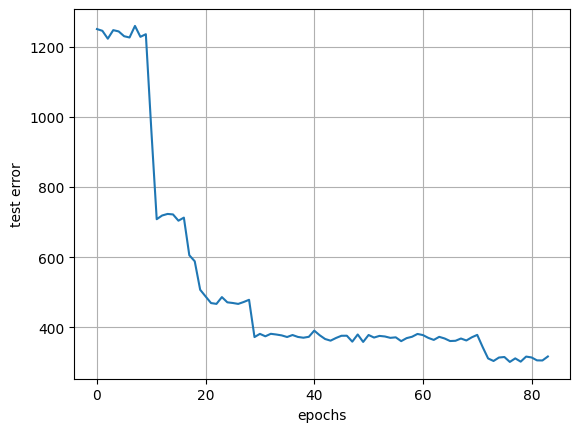

In [ ]:
plt.figure()
plt.grid()
plt.plot(np.arange(len(test_loss_list)), test_loss_list, label="test loss")
plt.xlabel("epochs")
plt.ylabel("test error")
plt.show()

In [ ]:
# To make the decoder available for future use, save after training:

decoder_params = svi.get_params(svi_state)["decoder$params"]
args["decoder_params"] = decoder_params

In [ ]:
with open('decoder_params_28.pkl', 'wb') as f:
    pickle.dump(args, f)

In [ ]:
with open('decoder_params_28.pkl', 'rb') as f:
    decoder_params = pickle.load(f)

In [ ]:
args["decoder_params"] = decoder_params['decoder_params']

#Obtain VAE samples

In [ ]:
def vae_sample(z_dim=args["z_dim"]):
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], len(args["x"]))
    decoder_params = args["decoder_params"]
    f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))

In [ ]:
rng_key, rng_key_predict = random.split(random.PRNGKey(2))
vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = vae_predictive(rng_key_predict)['f']

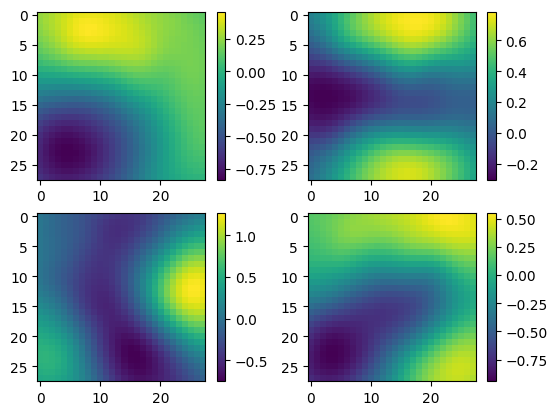

In [ ]:
plt.subplot(2, 2, 1)
plt.imshow(vae_draws[1].reshape((args['n'], args['n'])))
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(vae_draws[2].reshape((args['n'], args['n'])))
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(vae_draws[3].reshape((args['n'], args['n'])))
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(vae_draws[4].reshape((args['n'], args['n'])))
plt.colorbar()

In [ ]:
def mean_img(draws):
  sum = 0
  for img in draws:
    img = img.reshape((args['n'], args['n']))
    sum = sum + img
  sum = sum/len(draws)
  return(sum)

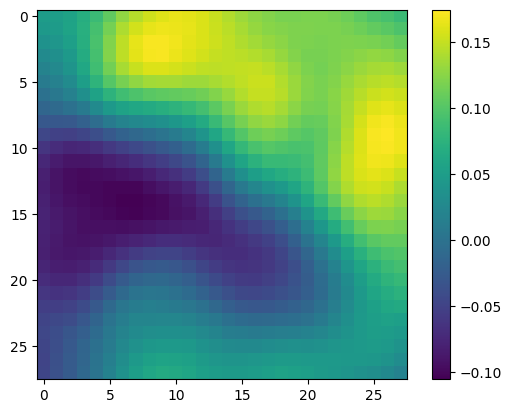

In [ ]:
heatmap2d(mean_img(vae_draws))

In [ ]:
cov_list = []
for i in range(len(vae_draws)):
  img = vae_draws[i].reshape((args['n'], args['n']))
  img = np.asarray(img)
  cov_list.append(np.cov(img, rowvar = False))

In [ ]:
upper_matrix = np.zeros((28, 28))
lower_matrix = np.zeros((28, 28))

In [ ]:
for i in range(28):
  for j in range(28):
    val_list = []
    for draw in cov_list:
      val_list.append(draw[i][j])
    val_list.sort()
    upper_matrix[i][j] = val_list[949]
    lower_matrix[i][j] = val_list[49]

In [ ]:
sample_cov = jnp.cov(vae_draws, rowvar = False)

In [ ]:
length = 1
var = 0.1
jitter = 1e-5
kernel_matrix = exp_sq_kernel(x, x, var, length, jitter)
mse = (jnp.square(sample_cov - kernel_matrix)).mean(axis=None)

In [ ]:
mse

Array(0.00477014, dtype=float32)

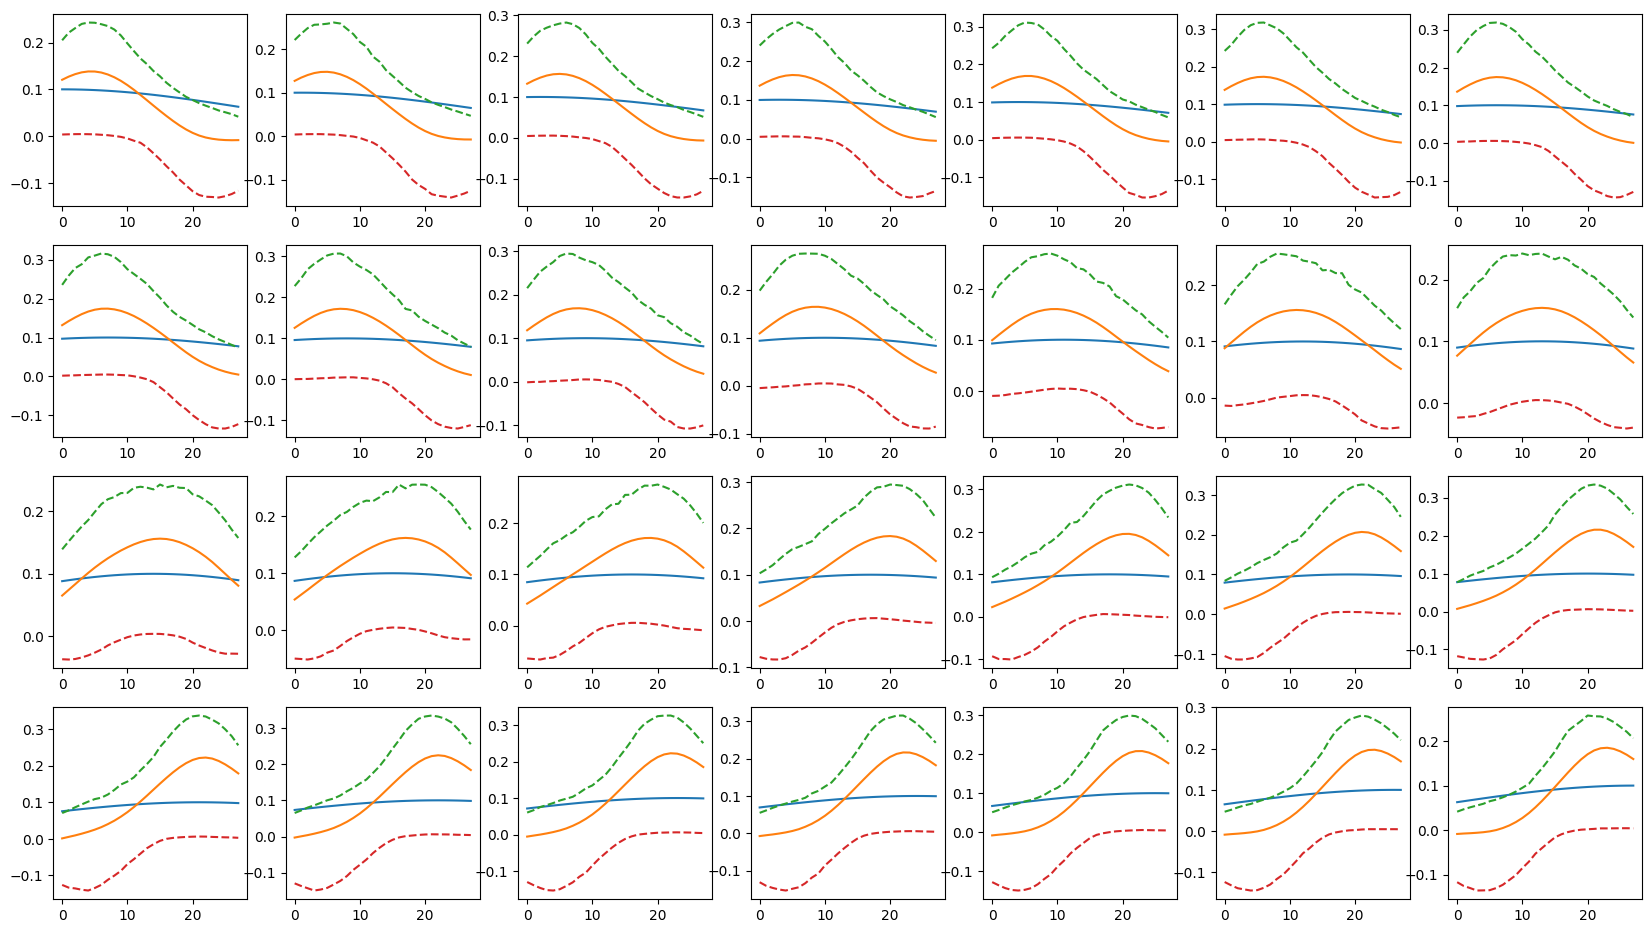

In [ ]:
x = [i for i in range(28)]
fig, ax = plt.subplots(nrows=4, ncols = 7)
fig.set_size_inches(20.5, 11.5)
for i in range(28):
  y1 = kernel_matrix[i][0:28]
  y2 = sample_cov[i][0:28]
  y3 = upper_matrix[i][0:28]
  y4 = lower_matrix[i][0:28]
  ax[i//7, i%7].plot(x, y1)
  ax[i//7, i%7].plot(x, y2)
  ax[i//7, i%7].plot(x, y3, linestyle = '--')
  ax[i//7, i%7].plot(x, y4, linestyle = '--')

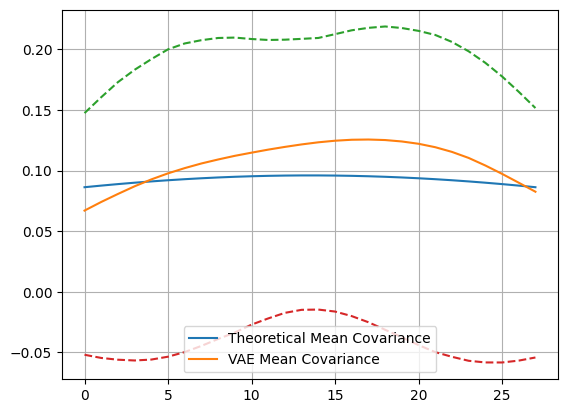

In [ ]:
y1_list = []
y2_list = []
y3_list = []
y4_list = []
for i in range(28):
  y1_list.append(kernel_matrix[i][0:28])
  y2_list.append(sample_cov[i][0:28])
  y3_list.append(upper_matrix[i][0:28])
  y4_list.append(lower_matrix[i][0:28])
y1 = sum(y1_list)/len(y1_list)
y2 = sum(y2_list)/len(y2_list)
y3 = sum(y3_list)/len(y3_list)
y4 = sum(y4_list)/len(y4_list)
plt.plot(x, y1, label='Theoretical Mean Covariance')
plt.plot(x, y2, label='VAE Mean Covariance')
plt.plot(x, y3, linestyle = '--')
plt.plot(x, y4, linestyle = '--')
plt.grid()
plt.legend()

#Performing MCMC inference

In [ ]:
covimod = pyreadr.read_r('pop.Rdata')['pop_df']

In [ ]:
pop_matrix = np.zeros((84, 84))

In [ ]:
covimod = covimod.to_numpy()

In [ ]:
for i in range(84):
  for j in range(84):
    pop_matrix[i][j] = covimod[101+i][2]

In [ ]:
pop_matrix_33 = np.zeros((28, 28))

In [ ]:
for i in range(84):
  for j in range(84):
    a = int(np.floor(i/3))
    b = int(np.floor(j/3))
    pop_matrix_33[a][b] = pop_matrix_33[a][b]+pop_matrix[i][j]

In [ ]:
logP = np.log(pop_matrix_33)
logP = jnp.asarray(logP)
args['logP'] = logP

In [ ]:
participants = pd.read_excel('Polymod Participants.xlsx')

In [ ]:
participants = participants.drop(columns=["Unnamed: 0", "Gender"])

In [ ]:
participants = participants.to_numpy()

In [ ]:
part = participants[0:84]

In [ ]:
part_matrix = np.zeros((84, 84))

In [ ]:
for i in range(84):
  for j in range(84):
    part_matrix[i][j] = part[j][1]

In [ ]:
part_matrix_33 = np.zeros((28, 28))
for i in range(84):
  for j in range(84):
    a = int(np.floor(i/3))
    b = int(np.floor(j/3))
    part_matrix_33[a][b] = part_matrix_33[a][b]+part_matrix[i][j]

In [ ]:
for i in range(28):
  for j in range(28):
    if part_matrix_33[i][j]==0:
      part_matrix_33[i][j]=1

In [ ]:
logN = jnp.log(jnp.asarray(part_matrix_33))

In [ ]:
args['logN'] = logN

In [ ]:
y_data = pd.read_excel("Y_Data.xlsx")

In [ ]:
y_data

,Number,Age,Gender,Alter-age,Alter-gender,Y
0,1,1,M,1,F,4
1,2,1,M,2,F,0
2,3,1,M,3,F,2
3,4,1,M,4,F,1
4,5,1,M,5,F,3
...,...,...,...,...,...,...
7051,7052,84,M,80,F,0
7052,7053,84,M,81,F,0
7053,7054,84,M,82,F,0
7054,7055,84,M,83,F,0


In [ ]:
y_0 = np.zeros((84, 84))
y_data = y_data.to_numpy()
for i in range(7056):
  j = int(y_data[i][1])-1
  l = int(y_data[i][3])-1
  k = int(y_data[i][5])
  y_0[j][l] = k

In [ ]:
y = np.zeros((28, 28))
for i in range(84):
  for j in range(84):
    a = int(np.floor(i/3))
    b = int(np.floor(j/3))
    y[a][b] = y[a][b]+y_0[i][j]

#Running MCMC

In [ ]:
def contact_model_VAE(args, y = None):

  P = args['logP']
  N = args['logN']
  n = args['n']

  decoder_params = args["decoder_params"]
  z_dim, hidden_dim = decoder_params[0][0].shape
  z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
  decoder_nn = vae_decoder(args["hidden_dim2"], args["hidden_dim1"], n)
  f = numpyro.deterministic("f", decoder_nn[1](decoder_params, z))
  f = jnp.reshape(f, (n, n))

  #fixed effects
  b0 = numpyro.sample('b0', dist.Normal(0, 10))
  v = numpyro.sample('v', dist.Exponential(1))
  tau = numpyro.sample('tau', dist.Normal(0, 1))
  rho = numpyro.sample('rho', dist.Normal(0, 1))

  lp = b0 + tau + f + P
  lu = lp + N + rho
  u = jnp.exp(lu)
  a = u/v

  if y is None:
    numpyro.sample("y_pred", dist.GammaPoisson(a, v/(1+v)))
  else:
    numpyro.sample("y", dist.GammaPoisson(a, v/(1+v)), obs=y)

In [ ]:
rng_key, rng_key_predict = random.split(random.PRNGKey(6))

# inference
start = time.time()
kernel = NUTS(contact_model_VAE)
mcmc_vae = MCMC(kernel, num_warmup=4000, num_samples=10000, num_chains = args['num_chains'], thinning = args['thinning'])
mcmc_vae.run(rng_key, args, y = y),
t_elapsed = time.time() - start

prev_samples = mcmc_vae.get_samples()
#mcmc.print_summary()

<ipython-input-94-0aceb5895f7f>:6: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_vae = MCMC(kernel, num_warmup=4000, num_samples=10000, num_chains = args['num_chains'], thinning = args['thinning'])
warmup:   2%|▏         | 320/14000 [01:16<32:26,  7.03it/s, 127 steps of size 3.87e-02. acc. prob=0.78]

In [ ]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
r = np.mean(ss['f']['n_eff'])
print("Average ESS for all VAE effects : " + str(round(r)))


MCMC elapsed time: 1892 s
Average ESS for all VAE effects : 4082


In [ ]:
y_list = []
for i in range(len(samples['f'])):
  b0 = samples['b0'][i]
  rho = samples['rho'][i]
  tau = samples['tau'][i]
  f = samples['f'][i]
  v = samples['v'][i]
  f = f.reshape(args['n'], args['n'])
  lm = f + b0 + logP + tau
  m_pred = jnp.exp(lm)
  lu = lm + rho + logN
  u = jnp.exp(lu)
  a = u/v
  rng_key, rng_key_predict = random.split(random.PRNGKey(12))
  y_pred = numpyro.sample('y', dist.GammaPoisson(a, v/(1+v)), rng_key = rng_key)
  y_list.append(y_pred)
y_avg = sum(y_list)/len(y_list)

In [ ]:
np.abs(np.mean(y_avg-y))

0.13271922

In [ ]:
m_new = y_pred/part_matrix_33

In [ ]:
np.abs(np.mean(m_new-y/part_matrix_33))

0.01154099

In [ ]:
prev_samples_vae_az = az.from_numpyro(mcmc_vae)

array([[<Axes: title={'center': 'b0'}>, <Axes: title={'center': 'b0'}>]],
      dtype=object)

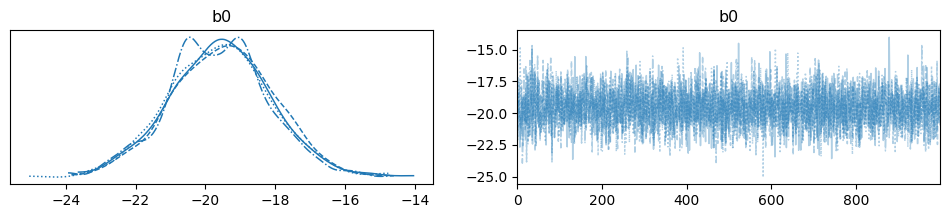

In [ ]:
az.plot_trace(prev_samples_vae_az, var_names = ("b0"))

array([[<Axes: title={'center': 'rho'}>, <Axes: title={'center': 'rho'}>],
       [<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>]],
      dtype=object)

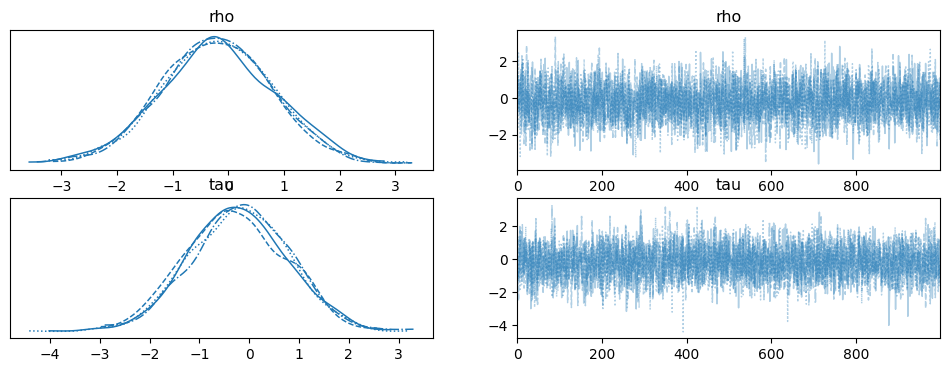

In [ ]:
az.plot_trace(prev_samples_vae_az, var_names = ("rho", "tau"))